In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd
from scipy.spatial import distance_matrix
import numpy as np
import matplotlib.pyplot as plt
import itertools
import copy
from collections import Counter
from TrackReconstruction_functions import *
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
%matplotlib widget

pd.options.mode.chained_assignment = None  # Disable the warning

pressure=1
# diffusion="5.0percent"
diffusion="5percent"
# file_id = "1"
# file_id = "2954"
file_id = "2638"


hits = pd.read_hdf(f"../data/Trackreco/ATPC_Tl_{pressure}bar_{diffusion}_filtered.h5", "MC/hits")
hits_true = pd.read_hdf(f"../data/Trackreco/ATPC_Tl_{pressure}bar_nexus_filtered.h5", "MC/hits")

display(hits)

event_list = hits.event_id.unique()

eid=event_list[7]

data = hits[hits.event_id ==eid]
# data = CutandRedistibuteEnergy(data, 0.0004)

data_true = hits_true[hits_true.event_id == eid]
data_true["z"] = data_true["z"]+3000

# print(hits.event_id.unique())

,event_id,x,y,z,energy
96549,37855031,-2509.936523,2415.623779,2624.910400,0.000025
96550,37855031,-2518.829834,2419.020508,2631.673096,0.000248
96551,37855031,-2517.892578,2425.521973,2631.958496,0.000025
96552,37855031,-2511.896240,2403.260986,2632.836182,0.000074
96553,37855031,-2510.721191,2430.207031,2633.005371,0.000074
...,...,...,...,...,...
75854,33655022,2011.740356,-84.224716,4060.085938,0.000025
75855,33655022,2038.198486,-61.271431,4061.869385,0.000099
75856,33655022,2050.229736,-71.848473,4066.176758,0.000074
75857,33655022,2053.497559,-80.056831,4067.518066,0.000025


In [6]:
mean_sigma = round(4*0.29*np.sqrt(0.1*data.z.mean()))
print("mean_sigma:", mean_sigma)

# Calculate the detector half-length
det_size = int(np.cbrt(6000**3/pressure)/2.0) 

# This shifts the z pos of the events so 0 is at anode
z_shift = det_size

zmin=-det_size + z_shift - mean_sigma/2 
xmin=-det_size - mean_sigma/2 
ymin=-det_size - mean_sigma/2 


mean_sigma: 19


In [7]:
reco_DE_event = data.copy()

# voxel size and parameters
voxel_size = 10  # mm
threshold = mean_sigma*1.1  # Distance threshold for voxel grouping
threshold = voxel_size*2.1

df_merged = GroupHits(reco_DE_event, xmin, ymin, zmin, voxel_size, threshold)
display(df_merged)



,event_id,x,y,z,energy,group_id
0,50770055,-1280.115234,618.793762,2482.490967,0.000149,0
1,50770055,-1272.688721,622.412842,2483.236572,0.000099,0
2,50770055,-1278.350220,612.881226,2483.820557,0.000124,0
3,50770055,-1277.392578,625.434937,2484.339111,0.000025,0
4,50770055,-1268.483032,626.397339,2484.462402,0.000025,0
...,...,...,...,...,...,...
2886,50770055,-829.922791,1126.336060,2968.684570,0.000025,1
2887,50770055,-813.583801,1103.985840,2968.685059,0.000099,1
2888,50770055,-813.163635,1117.532471,2968.813965,0.000050,1
2889,50770055,-813.046143,1107.822754,2976.199707,0.000025,1


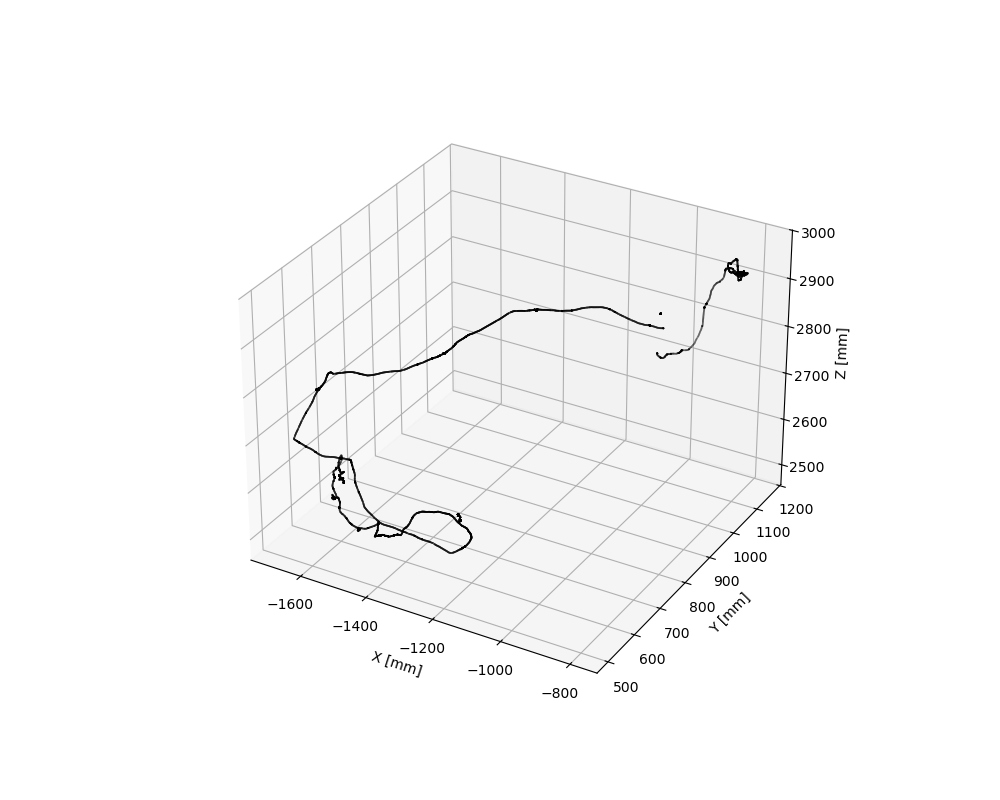

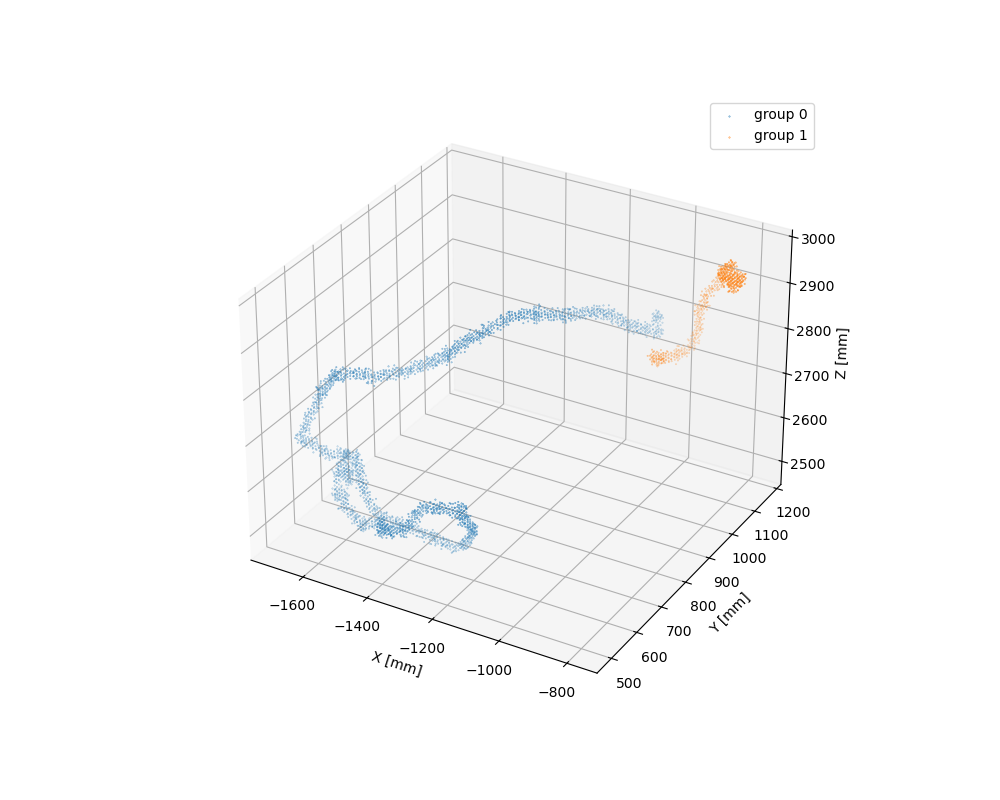

In [8]:

fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(111, projection='3d')
ax1.scatter(data_true['x'], data_true['y'], data_true['z'],c="k", s=0.1)
# ax1.scatter(data['x'], data['y'], data['z'],c="k", s=0.1)

ax1.set_xlabel("X [mm]")
ax1.set_ylabel("Y [mm]")
ax1.set_zlabel("Z [mm]")


fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(111, projection='3d')
for gid in sorted(df_merged["group_id"].unique()):
    temp_df = df_merged[df_merged.group_id == gid]
    ax1.scatter(temp_df['x'], temp_df['y'], temp_df['z'], s=0.1, label = f"group {gid}")
    # ax1.scatter(data['x'], data['y'], data['z'],c="k", s=0.1)

    ax1.set_xlabel("X [mm]")
    ax1.set_ylabel("Y [mm]")
    ax1.set_zlabel("Z [mm]")
    ax1.legend()
